In [1]:
using Turing
using LimberJack
using CSV
using NPZ
using Plots
using FITSIO
using Plots
using LinearAlgebra
using Distributed
using StatsPlots
using Optim

┌ Info: Precompiling LimberJack [6b86205d-155a-4b14-b82d-b6a149ea78f2]
└ @ Base loading.jl:1423


In [2]:
files = npzread("../data/DESY1_cls/Cls_meta.npz")
Cls_meta = cls_meta(files)

cls_meta{Vector{Vector{Int64}}}([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3]], [[1, 0, 1, 0], [1, 1, 1, 1], [1, 2, 1, 2], [1, 3, 1, 3], [1, 4, 1, 4], [1, 0, 2, 0], [1, 0, 2, 1], [1, 0, 2, 2], [1, 0, 2, 3], [1, 1, 2, 0]  …  [2, 0, 2, 0], [2, 0, 2, 1], [2, 0, 2, 2], [2, 0, 2, 3], [2, 1, 2, 1], [2, 1, 2, 2], [2, 1, 2, 3], [2, 2, 2, 2], [2, 2, 2, 3], [2, 3, 2, 3]], [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 6]  …  [6, 6], [6, 7], [6, 8], [6, 9], [7, 7], [7, 8], [7, 9], [8, 8], [8, 9], [9, 9]])

In [3]:
cov_tot = files["cov"]
inv_cov_tot = files["inv_cov"]
data_vector = files["cls"];

In [4]:
Carlos_numbers = [[10340.7,      4.986333e-02,    2.485272e-01,    1.408822e+00,    9.548656e-01,    7.668266e-01,    2.983905e-01,    1.405038e+00],                                                                                                                  
                  [9581.83,      3.117922e-02,    2.482170e-01,    1.391588e+00,    9.534284e-01,    6.401334e-01,    2.793962e-01,    1.342951e+00],                                                                                                                  
                  [4849.68,      3.568697e-02,    2.503540e-01,    1.268360e+00,    9.575103e-01,    7.224773e-01,    2.860409e-01,    1.238500e+00],                                                                                                                  
                  [473.158,      4.269041e-02,    2.491708e-01,    9.452725e-01,    9.624301e-01,    7.283836e-01,    2.918613e-01,    9.323621e-01],                                                                                                                  
                  [377.691,      5.382506e-02,    2.496367e-01,    7.521676e-01,    9.678393e-01,    7.183957e-01,    3.034617e-01,    7.564949e-01],                                                                                                                  
                  [305.879,      6.137468e-02,    2.453275e-01,    7.910198e-01,    9.719094e-01,    6.341343e-01,    3.067021e-01,    7.998069e-01],                                                                                                                  
                  [286.311,      5.677231e-02,    2.449374e-01,    8.355840e-01,    9.692330e-01,    6.101292e-01,    3.017097e-01,    8.379616e-01],                                                                                                                  
                  [276.895,      3.362121e-02,    2.450259e-01,    8.656761e-01,    9.693195e-01,    6.860718e-01,    2.786471e-01,    8.342997e-01]];
cls_carlos = npzread("../data/DESY1_cls/cl_cross_corr_step_info.npz")

Dict{String, Any} with 6 entries:
  "chi2_nolp" => 584.712
  "chi2"      => -589.279
  "res"       => [0.293036, -0.323474, 0.254464, -0.86567, 1.58544, -0.128693, …
  "chi2dof"   => -1.25379
  "cls"       => [0.000172898, 7.89916e-5, 4.09224e-5, 2.56082e-5, 1.77054e-5, …
  "lp_chi2"   => -4.56769

In [5]:
b0 = 1.41
b1 = 1.62
b2 = 1.60
b3 = 1.92
b4 = 2.0
dz_g0 = 0.001
dz_g1 = 0.001
dz_g2 = 0.001
dz_g3 = 0.001
dz_g4 = 0.001
dz_k0 = 0.001
dz_k1 = 0.001
dz_k2 = 0.001
dz_k3 = 0.001
m0 = 0.001
m1 = 0.001
m2 = 0.001
m3 = 0.001
A_IA = 0.001
alpha_IA = 0.001

nuisances = Dict("b0" => b0,
                 "b1" => b1,
                 "b2" => b2,
                 "b3" => b3,
                 "b4" => b4,
                 "dz_g0" => dz_g0,
                 "dz_g1" => dz_g1,
                 "dz_g2" => dz_g2,
                 "dz_g3" => dz_g3,
                 "dz_g4" => dz_g4,
                 "dz_k0" => dz_k0,
                 "dz_k1" => dz_k1,
                 "dz_k2" => dz_k2,
                 "dz_k3" => dz_k3,
                 "m0" => m0,
                 "m1" => m1,
                 "m2" => m2,
                 "m3" => m3,
                 "A_IA" => A_IA,
                 "alpha_IA" => alpha_IA)

cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
cls = Theory(cosmology, nuisances, Cls_meta, files);

In [6]:
using Trapz 
function angularCℓ2(cosmo, t1, t2, ℓ; res=200)
    # OPT: we are not optimizing the limits of integration
    logks = LinRange(log(10^-4),log(10^2), res)
    integrand = [Cℓintegrand(cosmo, t1, t2, logk, ℓ)/(ℓ+0.5) for logk in logks]
    Cℓ = trapz(logks, integrand)
    fℓ1 = get_Fℓ(t1, ℓ)
    fℓ2 = get_Fℓ(t2, ℓ)
    return Cℓ * fℓ1 * fℓ2
end

angularCℓ2 (generic function with 1 method)

In [7]:
z = range(0., stop=2., length=256)
nz = @. exp(-0.5*((z-0.5)/0.05)^2)
tg = NumberCountsTracer(cosmology, z, nz, 2.)
ℓs = [10, 30, 100, 300]
Cℓ_gg_bm = [7.57445927e-05, 8.26337569e-05, 3.02763731e-05, 5.86734959e-06]
Cℓ_gg = [angularCℓ2(cosmology, tg, tg, ℓ; res=200) for ℓ in ℓs]

4-element Vector{Float64}:
 7.578304876768499e-5
 8.251155304472611e-5
 3.018615703416361e-5
 5.858161439616809e-6

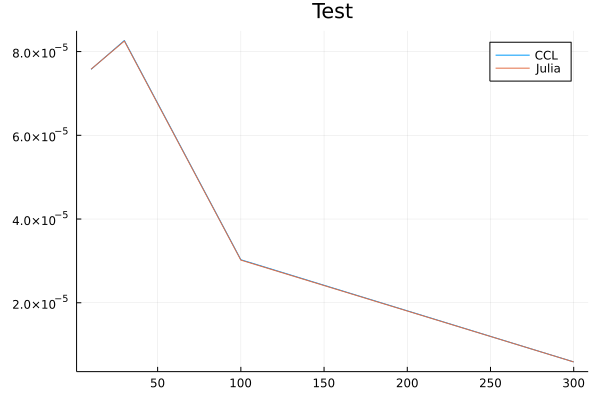

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [8]:
plot(ℓs, Cℓ_gg_bm, label="CCL", title="Test")
plot!(ℓs, Cℓ_gg, label="Julia")

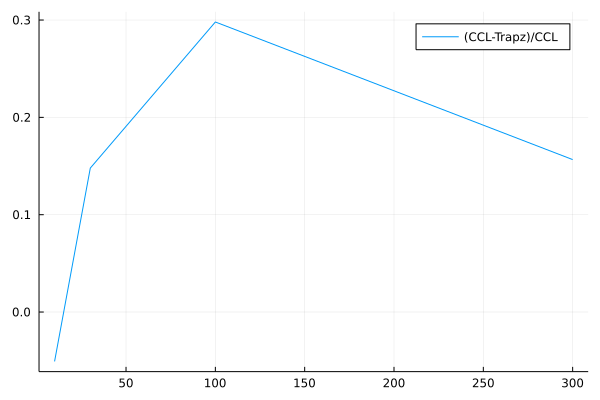

In [9]:
plot(ℓs, @.(100*(Cℓ_gg_bm-Cℓ_gg)/Cℓ_gg_bm), label="(CCL-Trapz)/CCL")

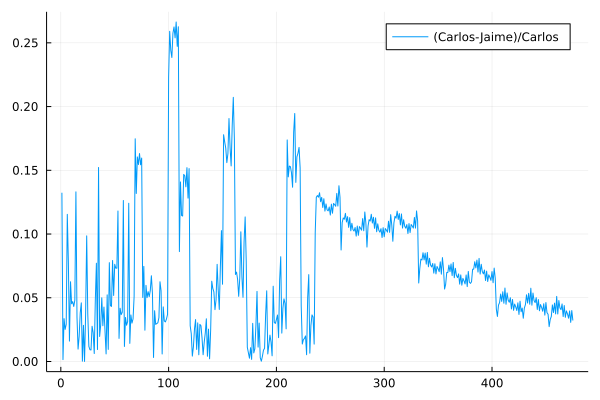

In [10]:
cls_jaime = vcat(cls...)
plot(@.(abs(cls_carlos["cls"]-cls_jaime)/cls_carlos["cls"]), label="(Carlos-Jaime)/Carlos")

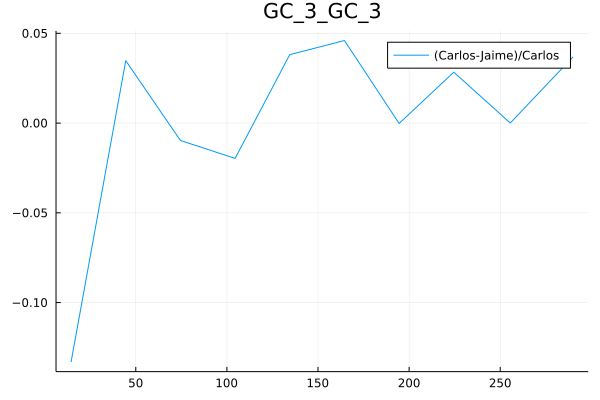

In [11]:
cl_n = 3
pair = Cls_meta.pairs[cl_n]
ls = files[string("ls_", pair[1], pair[2], pair[3], pair[4])]
cl_jaime = cls[cl_n]
len_cl = length(cl_jaime)
past_ls_len = 1
for i in 1:(cl_n-1)
    past_ls_len = past_ls_len + length(cls[i])
end
cl_carlos = cls_carlos["cls"][past_ls_len:past_ls_len+len_cl-1]
plot(ls, @.((cl_carlos-cl_jaime)/cl_carlos), label="(Carlos-Jaime)/Carlos", title="GC_$(cl_n)_GC_$(cl_n)")# yaxis=:log)
#plot!(cl_jaime, label="Jaime")#, yaxis=:log)

In [14]:
benchmarks = npzread("../test/benchmarks.npz")
benchmarks["Cls_g2g2"]

LoadError: SystemError: opening file "../test/benchmarks.npz": No such file or directory

In [13]:
cl_n = 5
pair = Cls_meta.pairs[cl_n]
ls = files[string("ls_", pair[1], pair[2], pair[3], pair[4])]
cl_jaime = cls[cl_n]
len_cl = length(cl_jaime)
past_ls_len = 1
for i in 1:(cl_n-1)
    past_ls_len = past_ls_len + length(cls[i])
end
cl_carlos = cls_carlos["cls"][past_ls_len:past_ls_len+len_cl-1]
plot(ls, cl_carlos, label="Carlos", title="GC_$(cl_n)_GC_$(cl_n)")
plot!(ls, cl_jaime, label="Jaime")#, yaxis=:log)
plot!(ls, benchmarks["Cls_g$(cl_n)g$(cl_n)"], label="ccl")#, yaxis=:log)

LoadError: UndefVarError: benchmarks not defined

In [73]:
function get_Xi2(cosmo_pars)
    Ωm = cosmo_pars[6]
    Ωb = cosmo_pars[1]
    h = cosmo_pars[5]
    ns = cosmo_pars[4]
    s8 = cosmo_pars[3]
    println(Ωm, Ωb, h, ns, s8)
    
    b0 = 1.41
    b1 = 1.62
    b2 = 1.60
    b3 = 1.92
    b4 = 2.0
    
    nuisances = Dict("b0" => b0,
                     "b1" => b1,
                     "b2" => b2,
                     "b3" => b3,
                     "b4" => b4)
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = vcat(Theory(cosmology, nuisances, Cls_meta, files)...)
    diff = @.(data_vector-theory)
    Xi2 = dot(diff,inv_cov_tot'diff)
    return Xi2
end;

In [74]:
dXi2 = []
for numbers in Carlos_numbers
    Xi2_true = 2*numbers[1]
    cosmo_pars = numbers[2:7]
    Xi2 = get_Xi2(cosmo_pars)
    push!(dXi2, abs(Xi2-Xi2_true)/Xi2_true)
end

0.29839050.049863330.76682660.95486561.408822
0.27939620.031179220.64013340.95342841.391588
0.28604090.035686970.72247730.95751031.26836
0.29186130.042690410.72838360.96243010.9452725
0.30346170.053825060.71839570.96783930.7521676
0.30670210.061374680.63413430.97190940.7910198
0.30170970.056772310.61012920.9692330.835584
0.27864710.033621210.68607180.96931950.8656761


In [75]:
dXi2

8-element Vector{Any}:
 0.05323408004939123
 0.04519470749593247
 0.056722564121618274
 0.04541358841541439
 0.04599377797161013
 0.03125548899702635
 0.0068285251345881585
 0.0013609115783669915

In [76]:
@model function model(data_vector::Vector{Float64})
    Ωm ~ Uniform(0.1, 0.5)
    h = 0.67 #~ Uniform(0.6, 0.8)
    s8 ~ Uniform(0.6, 1.0)
    
    b0 = 1.41 #~ Uniform(1.0, 3.0)
    b1 = 1.62 #~ Uniform(1.0, 3.0)
    b2 = 1.60 #~ Uniform(1.0, 3.0)
    b3 = 1.92 #~ Uniform(1.0, 3.0)
    b4 = 2.00 #~ Uniform(1.0, 3.0)
    
    nuisances = Dict("b0" => b0,
                     "b1" => b1,
                     "b2" => b2,
                     "b3" => b3,
                     "b4" => b4)
    
    cosmology = LimberJack.Cosmology(Ωm, 0.05, h, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = vcat(Theory(cosmology, nuisances, Cls_meta, files)...)
    data_vector ~ MvNormal(theory, cov_tot)
    return data_vector
end;

In [77]:
map_estimate = optimize(model(data_vector), MAP(), NelderMead())

ModeResult with maximized lp of 8572.55
2-element Named Vector{Float64}
A   │ 
────┼─────────
:Ωm │ 0.263268
:s8 │ 0.850954

In [78]:
iterations = 1000
nadapts = 100

MH_chain = sample(model(data_vector), MH(), iterations,
            nadapt=nadapts, progress=true; save_state=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:23:31


In [79]:
describe(MH_chain)[1]

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2565    0.0102     0.0003    0.0014     7.9290    1.0946     ⋯
          s8    0.8457    0.0040     0.0001    0.0003   129.3912    1.0116     ⋯
                                                                1 column omitted


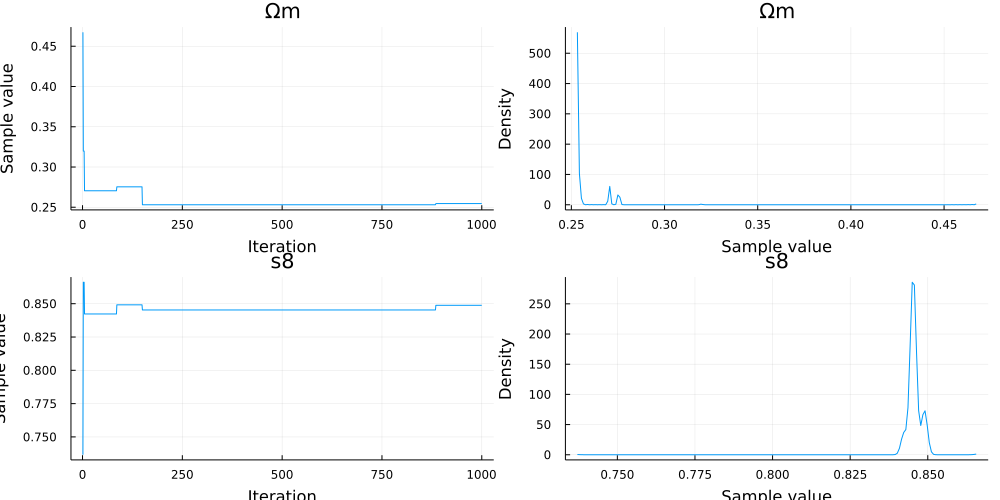

In [80]:
plot(MH_chain)

In [81]:
iterations = 1000
adaptation = 100
TAP = 0.6

NUTS_chain = sample(model(data_vector), NUTS(adaptation, TAP),
            iterations, progress=true; save_state=true);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/jaime/.julia/packages/Turing/uMoX1/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/w90s5/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:30:03


LoadError: InterruptException:

In [82]:
describe(NUTS_chain)[1]

LoadError: UndefVarError: NUTS_chain not defined

In [83]:
plot(NUTS_chain)

LoadError: UndefVarError: NUTS_chain not defined